## Import librarires

In [5]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Add libraries for SMOTE
from imblearn.over_sampling import SMOTE

## Load file

In [6]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,NaN,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,1,1,0.0,1.0,1,0.995567,0.0,0.000000,0.844384,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,0,0.995705,1.0,0.150000,0.831944,...,0,0,0,0,1,0,1,0,0,0


## Impute missing data
Using median strategy

In [7]:
def impute_missing_with_median(df):
    """
    Impute missing values in all columns of a DataFrame using the median strategy within each participant_id group, except for 'participant_id' and 'outcome'.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    skip_cols = ['participant_id', 'outcome']
    cols_to_impute = [col for col in df.columns if col not in skip_cols]
    df_result = df.copy()
    global_medians = df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group.median()
        fill_values = group_medians.fillna(global_medians)
        return group.fillna(fill_values)
    # Only apply groupby to columns to impute, avoiding the warning
    imputed = df[cols_to_impute].groupby(df['participant_id'], group_keys=False).apply(impute_group)
    df_result[cols_to_impute] = imputed
    return df_result

# Example usage:
raw_feature_df_scaled = impute_missing_with_median(raw_feature_df_scaled)

In [8]:
# Print the percentage of missing values for each column in raw_feature_df_scaled
missing_pct = raw_feature_df_scaled.isnull().mean() * 100
print("% Missing values per column:")
print(missing_pct.sort_values(ascending=False))

% Missing values per column:
participant_id               0.0
time_of_day_Afternoon        0.0
wake_day_part_2.0            0.0
wake_day_part_1.0            0.0
wake_day_part_0.0            0.0
location_category_Work       0.0
location_category_Transit    0.0
location_category_School     0.0
location_category_Other      0.0
location_category_Home       0.0
time_of_day_Night            0.0
time_of_day_Morning          0.0
time_of_day_Late Night       0.0
time_of_day_Evening          0.0
time_of_day_Early Morning    0.0
completion_since_start       0.0
outcome                      0.0
completion_since_wake        0.0
completion_24h               0.0
days_in_study                0.0
mims_5min                    0.0
closeness_to_wake_time       0.0
closeness_to_sleep_time      0.0
last_phone_usage             0.0
is_phone_locked              0.0
dist_from_home               0.0
screen_on                    0.0
charging_status              0.0
in_battery_saver_mode        0.0
is_weekend    

In [26]:
raw_feature_df_scaled.head(3)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,0.000013,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0


## Split training and test data
8 participants in training and 2 in testing

In [9]:
def split_train_test_by_participant(df, id_col='participant_id', n_train=8, n_test=2, random_state=42):
    """
    Splits the DataFrame into training and testing sets based on participant_id.
    n_train: number of unique participants in training set
    n_test: number of unique participants in test set
    Returns: train_df, test_df
    """
    np.random.seed(random_state)
    unique_ids = df[id_col].unique()
    shuffled_ids = np.random.permutation(unique_ids)
    train_ids = shuffled_ids[:n_train]
    test_ids = shuffled_ids[n_train:n_train+n_test]
    train_df = df[df[id_col].isin(train_ids)].reset_index(drop=True)
    test_df = df[df[id_col].isin(test_ids)].reset_index(drop=True)
    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (88178, 31)
Test set shape: (19897, 31)


In [10]:
# Print participant_ids in train and test sets
print("Train participant_ids:", sorted(train_df['participant_id'].unique()))
print("Test participant_ids:", sorted(test_df['participant_id'].unique()))

Train participant_ids: ['certifiedembargobartender@timestudy_com', 'chewingslouchingfailing@timestudy_com', 'enjoyergoofinessgrudge@timestudy_com', 'neutergoldfishsworn@timestudy_com', 'persevereriseswoop@timestudy_com', 'remoldexcludingaffair@timestudy_com', 'slapstickporcupineslacks@timestudy_com', 'subtitlegrievousbazooka@timestudy_com']
Test participant_ids: ['erasuresafeguardravishing@timestudy_com', 'pretendedconstrainfraying@timestudy_com']


In [11]:
# Create a table of participant_id, set (train/test), and number of observations
train_counts = train_df['participant_id'].value_counts().rename('n_observations').reset_index().rename(columns={'index': 'participant_id'})
train_counts['set'] = 'train'
test_counts = test_df['participant_id'].value_counts().rename('n_observations').reset_index().rename(columns={'index': 'participant_id'})
test_counts['set'] = 'test'
participant_table = pd.concat([train_counts, test_counts], ignore_index=True)
participant_table = participant_table[['participant_id', 'set', 'n_observations']]
participant_table = participant_table.sort_values(['set', 'participant_id']).reset_index(drop=True)
print(participant_table)

                            participant_id    set  n_observations
0  erasuresafeguardravishing@timestudy_com   test            4457
1  pretendedconstrainfraying@timestudy_com   test           15440
2  certifiedembargobartender@timestudy_com  train           11555
3    chewingslouchingfailing@timestudy_com  train           13283
4     enjoyergoofinessgrudge@timestudy_com  train           10457
5        neutergoldfishsworn@timestudy_com  train            8724
6         persevereriseswoop@timestudy_com  train           12993
7      remoldexcludingaffair@timestudy_com  train            6426
8   slapstickporcupineslacks@timestudy_com  train           11437
9    subtitlegrievousbazooka@timestudy_com  train           13303


## Apply SMOTE to training data
To handle the class imbalance

In [12]:
# Apply SMOTE to the training data to address class imbalance
feature_cols = [col for col in train_df.columns if col not in ['outcome', 'participant_id']]
X_train = train_df[feature_cols]
y_train = train_df['outcome']
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Convert back to DataFrame with feature names to avoid warning
X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_cols)
print('Original training set class distribution:')
print(y_train.value_counts())
print('Resampled training set class distribution:')
print(pd.Series(y_train_resampled).value_counts())

Original training set class distribution:
outcome
1    77724
0    10454
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    77724
0    77724
Name: count, dtype: int64


### Train a random forest classifier

In [13]:
def train_random_forest_classifier(X, y, random_state=42):
    """
    Trains a RandomForestClassifier on the provided features and labels.
    Uses class_weight='balanced' to handle class imbalance.
    Returns the trained model.
    """
    clf = RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=10,
        max_features='sqrt',
        n_estimators=100,
        random_state=random_state
    )
    clf.fit(X, y)
    return clf

# Example usage:
rf_model = train_random_forest_classifier(X_train_resampled, y_train_resampled)

## Test the model

In [14]:
def evaluate_classifier_on_test(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates the classifier on test_df and returns accuracy, precision, recall, F1, and AUC.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}' if auc is not None else 'AUC: Not available')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

# Example usage:
results = evaluate_classifier_on_test(rf_model, test_df)

Accuracy: 0.3949
Precision: 0.8840
Recall: 0.2909
F1 Score: 0.4377
AUC: 0.7228


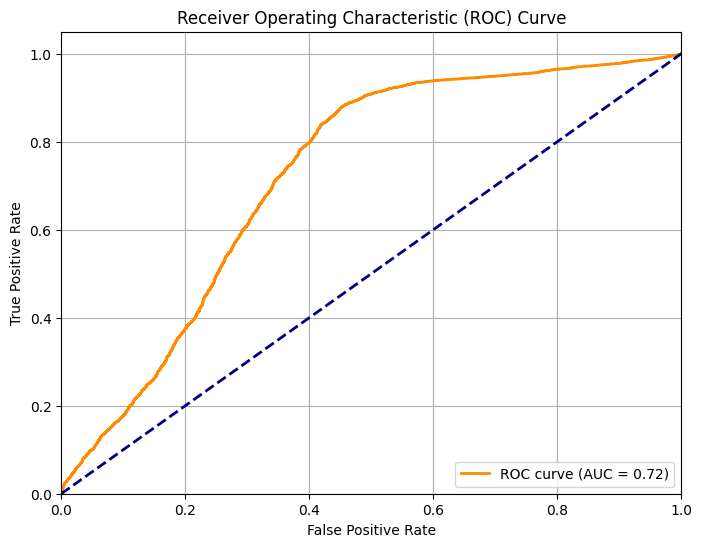

In [15]:
def plot_roc_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for the given model and test DataFrame.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot ROC curve.')
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example usage:
plot_roc_curve(rf_model, test_df)

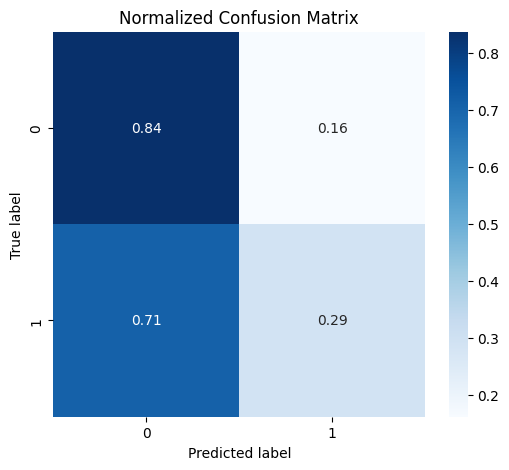

In [16]:
def plot_confusion_matrix(model, test_df, outcome_col='outcome', id_col='participant_id', cmap='Blues'):
    """
    Plots the normalized confusion matrix for the given model and test DataFrame.
    """
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage:
plot_confusion_matrix(rf_model, test_df)

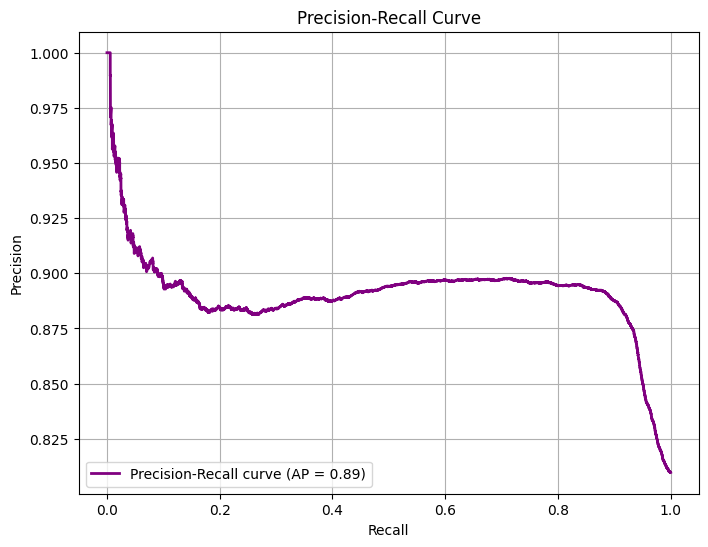

In [17]:
def plot_precision_recall_curve(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the precision-recall curve for the given model and test DataFrame.
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot precision-recall curve.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Example usage:
plot_precision_recall_curve(rf_model, test_df)

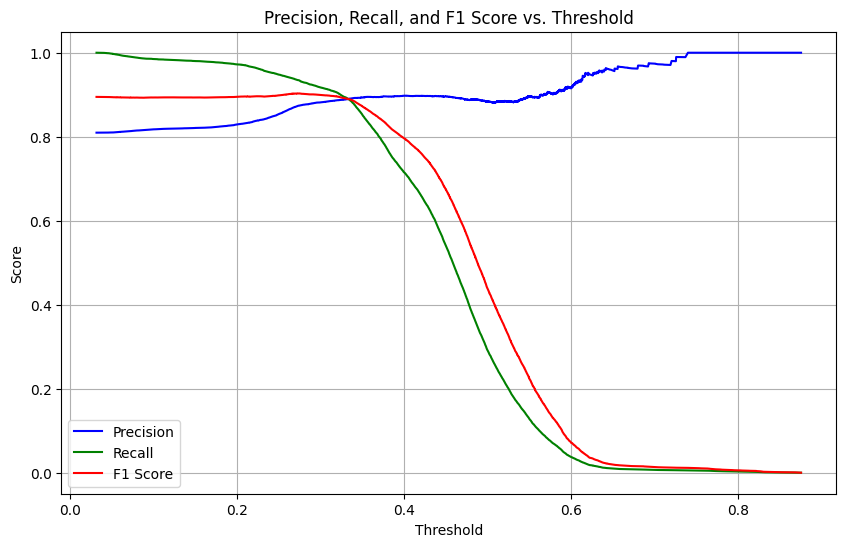

In [18]:
def plot_precision_recall_f1_vs_threshold(model, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots precision, recall, and F1 score as a function of the decision threshold for the given model and test DataFrame.
    """
    from sklearn.metrics import precision_recall_curve, f1_score
    import matplotlib.pyplot as plt
    import numpy as np
    feature_cols = [col for col in test_df.columns if col not in [outcome_col, id_col]]
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError('Model does not support predict_proba, cannot plot precision/recall/f1 vs. threshold.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    # F1 for each threshold (skip last threshold, as precision_recall_curve returns an extra value)
    f1 = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1.append(f1_score(y_test, y_pred, zero_division=0))
    f1 = np.array(f1)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
    plt.plot(thresholds, recall[:-1], label='Recall', color='green')
    plt.plot(thresholds, f1, label='F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_precision_recall_f1_vs_threshold(rf_model, test_df)

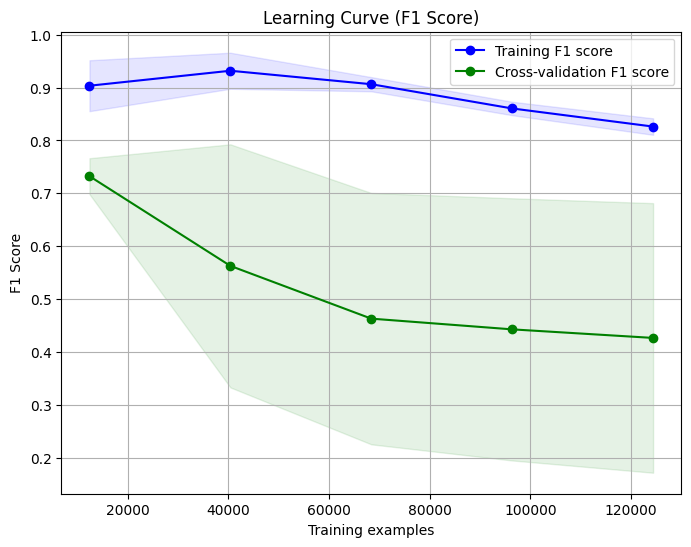

In [19]:
def plot_learning_curve(estimator, X, y, cv=5, train_sizes=None, random_state=42):
    """
    Plots the learning curve for the given estimator using F1 score as the metric.
    """
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 5)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='f1', train_sizes=train_sizes, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training F1 score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation F1 score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='green')
    plt.xlabel('Training examples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve (F1 Score)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage:
plot_learning_curve(rf_model, X_train_resampled, y_train_resampled)

### Grid search for hyper parameter tuning

In [20]:
def grid_search_random_forest(X, y, cv=5, random_state=42):
    """
    Performs grid search to find the best hyperparameters for RandomForestClassifier.
    Returns the best estimator and the grid search results as a DataFrame.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    import pandas as pd
    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'n_estimators': [100, 200]
    }
    clf = RandomForestClassifier(class_weight='balanced', max_features='sqrt', random_state=random_state)
    grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Best F1 score: {grid_search.best_score_:.4f}')
    results_df = pd.DataFrame(grid_search.cv_results_)
    return grid_search.best_estimator_, results_df

# Example usage:
best_rf_model, grid_results = grid_search_random_forest(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.7s
[CV] END max_depth=5, min_samples_leaf

/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  32.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  32.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  33.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  30.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estim

In [21]:
def train_best_model(best_estimator, X, y):
    """
    Retrains the best estimator from grid search on the full training data.
    Returns the trained model.
    """
    best_estimator.fit(X, y)
    return best_estimator

# Example usage:
final_rf_model = train_best_model(best_rf_model, X_train_resampled, y_train_resampled)

In [22]:
# Test the final_rf_model on the test data
final_results = evaluate_classifier_on_test(final_rf_model, test_df)

Accuracy: 0.6144
Precision: 0.9003
Recall: 0.5890
F1 Score: 0.7121
AUC: 0.7465


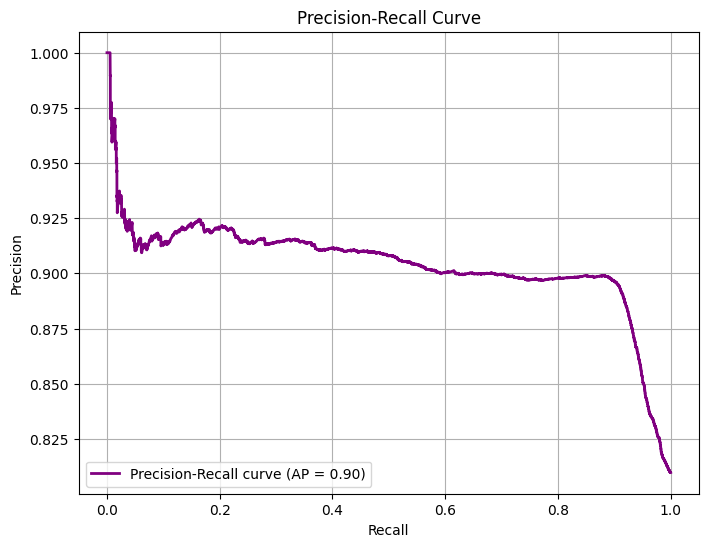

In [23]:
# Plot the precision-recall curve for the final_rf_model on the test data
plot_precision_recall_curve(final_rf_model, test_df)

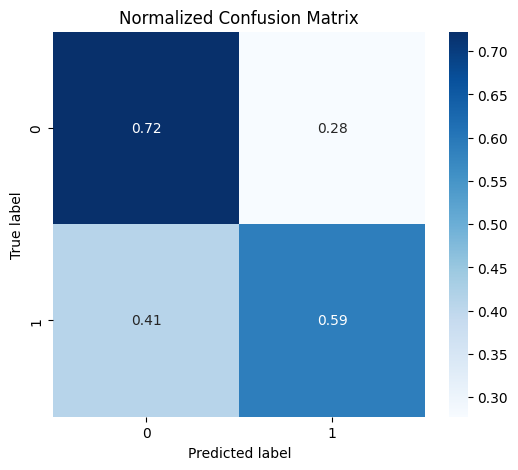

In [24]:
# Plot the normalized confusion matrix for the final_rf_model on the test data
plot_confusion_matrix(final_rf_model, test_df)

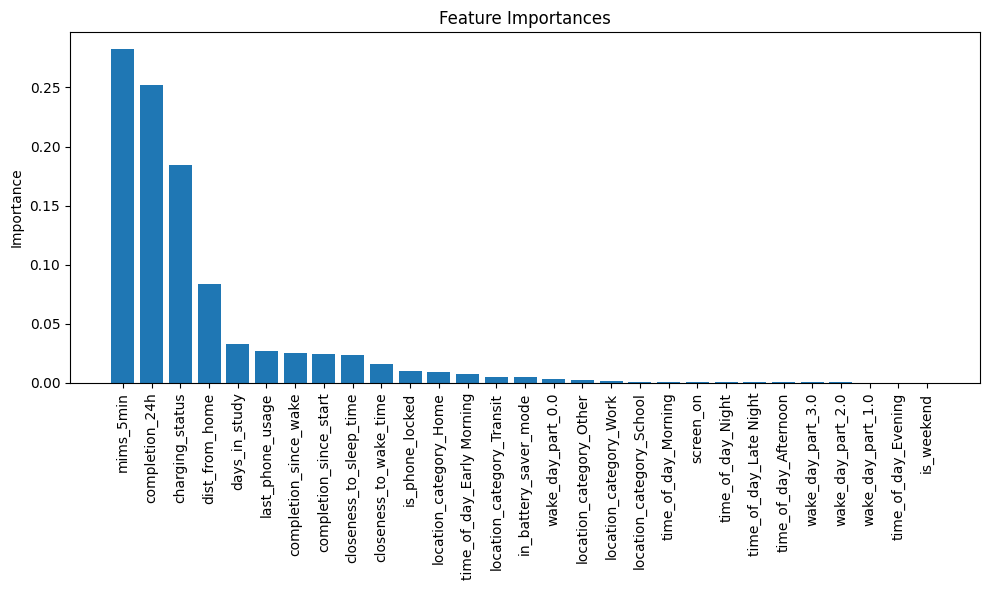

In [25]:
def plot_feature_importance(model, feature_names, top_n=None):
    """
    Plots the feature importances for a fitted RandomForest model.
    If top_n is specified, only the top_n features are shown.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    if top_n is not None:
        indices = indices[:top_n]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_importance(final_rf_model, X_train_resampled.columns)